In [1]:
# データセット作成

!pip install scipy

window_size = 1024
window_num_per_clip = 40
clip_size = window_size * window_num_per_clip
fft_sum_threshold = 50

from scipy.io.wavfile import read
import glob
import os
import numpy as np

def standardization(x):
    ret = np.log(x + 1) / np.log(np.finfo(np.float32).max)
    if (np.sum(ret) == 0):
        return ret
    else:
        return ret / np.sum(ret)

if os.path.isfile("../data/arrays/clips.npy"):
    print("clips.npy exists.")
    clips = np.load("../data/arrays/clips.npy")
else:
    files = glob.glob("../data/wav44100/*")
    #files = ["../data/wav44100/3DEmbodimentFromLines.wav"]
    raw_data_list = [read(file)[1] for file in files]

    clips = np.zeros((0, clip_size), dtype=np.int16)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save("../data/arrays/clips", clips)
    
    
if os.path.isfile("../data/arrays/fft_log.npy"):
    print("fft_log.npy exists.")
    fft = np.load("../data/arrays/fft_log.npy")
else:
    fft = np.zeros((0, window_num_per_clip, window_size))
    num = 0
    for clip in clips:
        print("fft progress: clip " + str(num))
        
        fft_tmp = np.zeros((0, window_size))
        tmp = [clip[i:i + window_size] for i in range(0, len(clip) - window_size + 1, window_size)]
        for tmp2 in tmp:
            spectrum = np.abs(np.fft.fft(tmp2))
            spectrum = standardization(spectrum)
            fft_tmp = np.vstack((fft_tmp, spectrum))
        fft = np.vstack((fft, fft_tmp.reshape(1, window_num_per_clip, window_size)))
        num += 1

    np.save("../data/arrays/fft_log", fft)
    
print("clips.shape: " + str(clips.shape))
print("fft.shape: " + str(fft.shape))

     |████████████████████████████████| 34.5 MB 15.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
clips.npy exists.
fft_log.npy exists.
clips.shape: (28576, 40960)
fft.shape: (28576, 40, 1024)


In [2]:
# 学習データとテストデータに分ける

train_data_rate = 0.8
fft_sum_threshold = 50

x = np.concatenate([fft[:-1, :, :], fft[1:, 0, :].reshape(fft.shape[0] - 1, 1, fft.shape[2])], 1)

x = np.delete(x, np.where(np.sum(x[:,0,:], axis=1) < fft_sum_threshold)[0], axis=0)
clips = np.delete(clips, np.where(np.sum(x[:,0,:], axis=1) < fft_sum_threshold)[0], axis=0)

p = np.random.permutation(len(x))
x = x[p]
clips = clips[p]

x_train = x[:int(x.shape[0] * train_data_rate), :window_num_per_clip, :].reshape(int(x.shape[0] * train_data_rate), window_num_per_clip, window_size, 1)
x_test = x[int(x.shape[0] * train_data_rate):, :window_num_per_clip, :].reshape(x.shape[0] - int(x.shape[0] * train_data_rate), window_num_per_clip, window_size, 1)
y_train = x[:int(x.shape[0] * train_data_rate), window_num_per_clip, :]
y_test = x[int(x.shape[0] * train_data_rate):, window_num_per_clip, :]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(np.max(x_train[0]))

(22237, 40, 1024, 1)
(5560, 40, 1024, 1)
(22237, 1024)
(5560, 1024)
0.12286324173860237


In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input
from keras.optimizers import Adam

learning_rate = 0.0001
 
model = keras.models.Sequential()
model.add(Conv2D(3, (3, 1), activation='relu', input_shape=(window_num_per_clip, window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 1024, 3)       12        
                                                                 
 dropout (Dropout)           (None, 38, 1024, 3)       0         
                                                                 
 flatten (Flatten)           (None, 116736)            0         
                                                                 
 dense (Dense)               (None, 512)               59769344  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [5]:
# 学習

history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/fft_batch256_e100")

Epoch 1/100
87/87 [==============================] - 51s 568ms/step - loss: 659.0135 - accuracy: 0.0000e+00 - val_loss: 737.0233 - val_accuracy: 0.0000e+00
Epoch 2/100
87/87 [==============================] - 49s 559ms/step - loss: 2499.7417 - accuracy: 6.2958e-04 - val_loss: 4087.9187 - val_accuracy: 0.0000e+00
Epoch 3/100
87/87 [==============================] - 48s 556ms/step - loss: 10559.9434 - accuracy: 3.5976e-04 - val_loss: 11740.5879 - val_accuracy: 0.0000e+00
Epoch 4/100
87/87 [==============================] - 48s 549ms/step - loss: 24252.4922 - accuracy: 0.0011 - val_loss: 23121.2266 - val_accuracy: 0.0000e+00
Epoch 5/100
87/87 [==============================] - 48s 556ms/step - loss: 42897.2695 - accuracy: 0.0012 - val_loss: 37745.3867 - val_accuracy: 0.0000e+00
Epoch 6/100
87/87 [==============================] - 48s 553ms/step - loss: 66143.1562 - accuracy: 0.0013 - val_loss: 55215.0430 - val_accuracy: 0.0000e+00
Epoch 7/100
87/87 [==============================] - 49s 5

87/87 [==============================] - 50s 572ms/step - loss: 3635591.0000 - accuracy: 0.0026 - val_loss: 2160480.7500 - val_accuracy: 0.0000e+00
Epoch 53/100
87/87 [==============================] - 50s 575ms/step - loss: 3744270.7500 - accuracy: 0.0024 - val_loss: 2281036.5000 - val_accuracy: 0.0000e+00
Epoch 54/100
87/87 [==============================] - 50s 571ms/step - loss: 3857947.2500 - accuracy: 0.0023 - val_loss: 2332992.0000 - val_accuracy: 0.0000e+00
Epoch 55/100
87/87 [==============================] - 49s 566ms/step - loss: 3963201.2500 - accuracy: 0.0019 - val_loss: 2419685.0000 - val_accuracy: 0.0000e+00
Epoch 56/100
87/87 [==============================] - 50s 574ms/step - loss: 4078544.7500 - accuracy: 0.0021 - val_loss: 2468037.5000 - val_accuracy: 0.0000e+00
Epoch 57/100
87/87 [==============================] - 50s 572ms/step - loss: 4189671.7500 - accuracy: 0.0024 - val_loss: 2519739.7500 - val_accuracy: 0.0000e+00
Epoch 58/100
87/87 [===========================

INFO:tensorflow:Assets written to: ../data/models/fft_batch256_e100/assets


INFO:tensorflow:Assets written to: ../data/models/fft_batch256_e100/assets


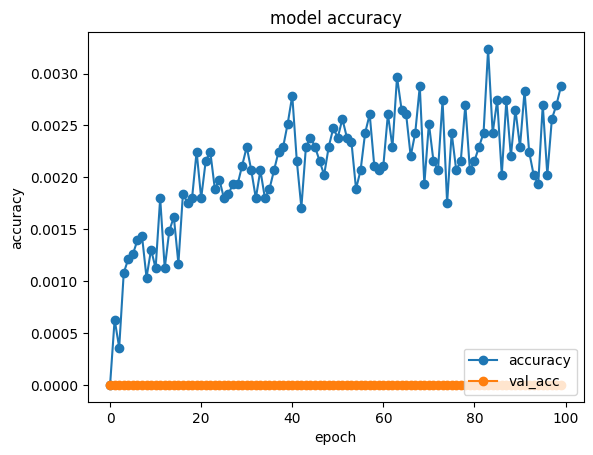

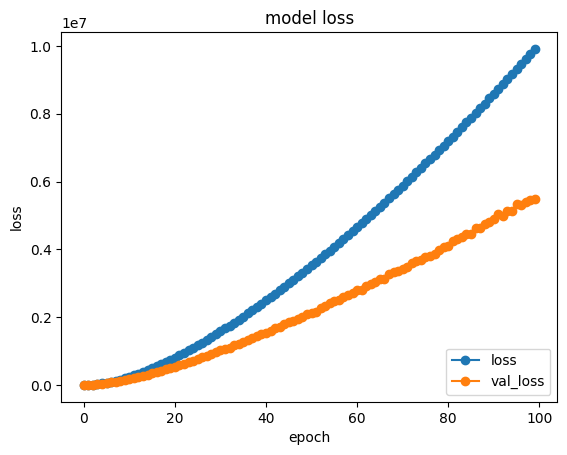

In [6]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [7]:
# 楽曲の出力

!pip install scikit-learn

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.io import wavfile
from keras.models import load_model

model = load_model("../data/models/fft_batch256_e100")

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index + int(x.shape[0] * train_data_rate)]))
    
wavfile.write("../data/out/fft_out_1.wav", 44100, out)

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index + int(x.shape[0] * train_data_rate)]))
    
wavfile.write("../data/out/fft_out_2.wav", 44100, out)

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index + int(x.shape[0] * train_data_rate)]))
    
wavfile.write("../data/out/fft_out_3.wav", 44100, out)

     |████████████████████████████████| 9.8 MB 126 kB/s eta 0:00:01     |████████████████▋               | 5.1 MB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 8.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
1/1 [==============================] - 0s 81ms/step
4154
1/1 [==============================] - 0s 34ms/step
4154
1/1 [==============================] - 0s 31ms/step
4154
1/1 [==============================] - 0s 36ms/step
4154
1/1 [==============================] - 0s 32ms/step
4154
1/1 [==============================] - 0s 33ms/step
4154
1/1 [==============================] - 0s 32ms/step
4154
1/1 [==============================] - 0s 31ms/step
4154
1/1 [==============================] - 0s 31ms/step
4154
1/1 [==============================] - 0s 32ms/step
4154
1/1 [==============================] - 0s 31ms/step
4154
1/1 [==============================] - 0s 32ms/step
4154
1/1 [=============